In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -U albumentations opencv-python
!pip install segmentation-models-pytorch

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.9 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import cv2
import numpy as np
import tarfile
import pandas as pd
import zipfile
from zipfile import ZipFile
import os
from random import sample
from os import listdir
import cv2
import numpy as np
from tqdm import tqdm
import time
from tempfile import TemporaryDirectory
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
images_dir = "/kaggle/input/isogd-256/isogd_256/images/"
masks_dir = "/kaggle/input/isogd-256/isogd_256/masks/"
names = listdir(images_dir)

data_df = pd.DataFrame(
    {
        "img_path": [images_dir + name for name in names],
        "mask_path": [masks_dir + name for name in names]
    }
)

In [8]:
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=121212)

In [43]:
"""images_train_dir = "/kaggle/input/skol-data/SKOL_DATA/train/images/"
masks_train_dir = "/kaggle/input/skol-data/SKOL_DATA/train/masks/"
names_train = listdir(images_train_dir)

train_df = pd.DataFrame(
    {
        "img_path": [images_train_dir + name for name in names_train],
        "mask_path": [masks_train_dir + name for name in names_train]
    }
)"""

In [44]:

"""images_val_dir = "/kaggle/input/skol-data/SKOL_DATA/valid/images/"
masks_val_dir = "/kaggle/input/skol-data/SKOL_DATA/valid/masks/"
names_val = listdir(images_val_dir)

val_df = pd.DataFrame(
    {
        "img_path": [images_val_dir + name for name in names_val],
        "mask_path": [masks_val_dir + name for name in names_val]
    }
)"""

In [9]:
transform_train = A.Compose([
    
    A.RandomRotate90(p=1),
    A.Normalize(),
    A.Resize(256, 256),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Normalize(),
    A.Resize(256, 256),
    ToTensorV2()
])

In [10]:
class BuildingDataset(Dataset):
  def __init__(self, df, transforms=None):
    self.df = df
    self.transforms = transforms

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx].img_path
    mask_path = self.df.iloc[idx].mask_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.float32(mask / 255)

    if self.transforms:
      aug = self.transforms(image=img, mask=mask)
      img = aug["image"]
      mask = aug["mask"]

    return img, mask

  def __len__(self):
    return len(self.df)

In [11]:
train_dataset = BuildingDataset(train_df, transform_train)
val_dataset = BuildingDataset(val_df, transform_val)

image_datasets = {
    "train": train_dataset,
    "val": val_dataset,
}

In [12]:
dataloaders = {
    data_type: DataLoader(
        image_datasets[data_type],
        batch_size=16,
        shuffle=True
        )
    for data_type in ["train", "val"]
}

dataset_sizes = {
    data_type: len(image_datasets[data_type]) for data_type in ['train', 'val']
    }

In [13]:
def train(model, criterion, optimizer, scheduler=None, num_epochs=5, save_path="./unet_resnet_perm.pt"):
    since = time.time()

    best_model_params_path = save_path

    torch.save(model.state_dict(), best_model_params_path)
    best_iou = 0.0
    best_f1 = 0.0
    best_loss = np.inf

    train_loss_lst = []
    val_loss_lst = []
    metric_f1_lst = []
    metric_iou_lst = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ["train", "val"]:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_iou = 0
            running_f1 = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                inputs = inputs.float()
                labels = labels.to(device)
                    
                # labels = torch.permute(labels, (0, 3, 1, 2))
                # inputs = torch.permute(inputs, (0, 3, 1, 2))
                labels = labels[:, np.newaxis, :, :]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print()
                    # print(f"outputs: {outputs.shape}")
                    # print(f"labels: {labels.shape}")
                    loss = criterion(outputs, labels)
                    # print(f"loss: {loss.item()}")

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # print()
                # print(f"inputs.size(0): {inputs.size(0)}")
                # print(f"loss: {loss.item()}")
                running_loss += loss.item() * inputs.size(0)
                # print(f"loss.item() * inputs.size(0): {loss.item() * inputs.size(0)}")

                if phase == "val":
                    y_pred = F.sigmoid(outputs)

                    # val_iou = iou_coef(labels, y_pred).cpu().detach().numpy()
                    tp, fp, fn, tn = smp.metrics.get_stats(y_pred, labels.long(), mode="binary", threshold=0.5)
                    val_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
                    val_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
                    running_iou += val_iou
                    running_f1 += val_f1

            if phase == 'train' and (not (scheduler is None)):
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == "val":
                epoch_iou = running_iou / len(dataloaders[phase])
                print(f'{phase} IOU: {epoch_iou:.4f}')
                epoch_f1 = running_f1 / len(dataloaders[phase])
                print(f'{phase} F1: {epoch_f1:.4f}')
                metric_iou_lst.append(epoch_iou)
                metric_f1_lst.append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            if phase == "train":
              train_loss_lst.append(epoch_loss)
            elif phase == "val":
              val_loss_lst.append(epoch_loss)

            # deep copy the model
            if phase == 'val':
                if epoch_iou > best_iou:
                    best_iou = epoch_iou
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1

            if phase == "val" and epoch_loss < best_loss:
                torch.save(model.state_dict(), best_model_params_path)
                # torch.save(model.state_dict(), "/content/drive/MyDrive/best.pt")
                best_loss = epoch_loss



    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')
    print(f'Best val IOU: {best_iou:4f}')
    print(f'Best val F1: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, {
        "train_loss": train_loss_lst,
        "val_loss": val_loss_lst,
        "metric_f1": metric_f1_lst,
        "metric_iou": metric_iou_lst
    }

In [14]:
model = smp.UnetPlusPlus()

model.load_state_dict(torch.load("/kaggle/input/unetpp-pretr/unetpp_resnet_pretr.pt", map_location=torch.device('cpu')))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.4MB/s]


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [15]:
criterion = smp.losses.DiceLoss(mode="binary")
optimizer = optim.AdamW(model.parameters())

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [16]:
res_model, proc_dict = train(model, criterion, optimizer, scheduler=exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------


100%|██████████| 453/453 [03:36<00:00,  2.09it/s]


train Loss: 0.3734


100%|██████████| 114/114 [00:34<00:00,  3.33it/s]


val IOU: 0.4916
val F1: 0.6548
val Loss: 0.3427
Epoch 1/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.14it/s]


train Loss: 0.3416


100%|██████████| 114/114 [00:17<00:00,  6.55it/s]


val IOU: 0.4812
val F1: 0.6443
val Loss: 0.3504
Epoch 2/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.3348


100%|██████████| 114/114 [00:16<00:00,  6.71it/s]


val IOU: 0.5166
val F1: 0.6764
val Loss: 0.3181
Epoch 3/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.14it/s]


train Loss: 0.3247


100%|██████████| 114/114 [00:17<00:00,  6.63it/s]


val IOU: 0.5227
val F1: 0.6822
val Loss: 0.3146
Epoch 4/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.3206


100%|██████████| 114/114 [00:17<00:00,  6.61it/s]


val IOU: 0.5208
val F1: 0.6817
val Loss: 0.3184
Epoch 5/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.3164


100%|██████████| 114/114 [00:17<00:00,  6.58it/s]


val IOU: 0.5408
val F1: 0.6986
val Loss: 0.3027
Epoch 6/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.12it/s]


train Loss: 0.3159


100%|██████████| 114/114 [00:17<00:00,  6.53it/s]


val IOU: 0.5358
val F1: 0.6947
val Loss: 0.3051
Epoch 7/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.3119


100%|██████████| 114/114 [00:17<00:00,  6.52it/s]


val IOU: 0.5334
val F1: 0.6907
val Loss: 0.3036
Epoch 8/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.11it/s]


train Loss: 0.3091


100%|██████████| 114/114 [00:18<00:00,  6.31it/s]


val IOU: 0.5333
val F1: 0.6905
val Loss: 0.3051
Epoch 9/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.12it/s]


train Loss: 0.3069


100%|██████████| 114/114 [00:17<00:00,  6.69it/s]


val IOU: 0.5515
val F1: 0.7068
val Loss: 0.2949
Epoch 10/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.12it/s]


train Loss: 0.2890


100%|██████████| 114/114 [00:17<00:00,  6.57it/s]


val IOU: 0.5625
val F1: 0.7169
val Loss: 0.2821
Epoch 11/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.2858


100%|██████████| 114/114 [00:17<00:00,  6.63it/s]


val IOU: 0.5634
val F1: 0.7174
val Loss: 0.2829
Epoch 12/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.2837


100%|██████████| 114/114 [00:17<00:00,  6.53it/s]


val IOU: 0.5661
val F1: 0.7203
val Loss: 0.2807
Epoch 13/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.12it/s]


train Loss: 0.2815


100%|██████████| 114/114 [00:17<00:00,  6.57it/s]


val IOU: 0.5662
val F1: 0.7207
val Loss: 0.2793
Epoch 14/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.2805


100%|██████████| 114/114 [00:17<00:00,  6.37it/s]


val IOU: 0.5698
val F1: 0.7235
val Loss: 0.2763
Epoch 15/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.11it/s]


train Loss: 0.2787


100%|██████████| 114/114 [00:17<00:00,  6.51it/s]


val IOU: 0.5664
val F1: 0.7204
val Loss: 0.2779
Epoch 16/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.11it/s]


train Loss: 0.2773


100%|██████████| 114/114 [00:17<00:00,  6.62it/s]


val IOU: 0.5705
val F1: 0.7231
val Loss: 0.2774
Epoch 17/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.12it/s]


train Loss: 0.2760


100%|██████████| 114/114 [00:17<00:00,  6.48it/s]


val IOU: 0.5694
val F1: 0.7222
val Loss: 0.2787
Epoch 18/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.2753


100%|██████████| 114/114 [00:17<00:00,  6.60it/s]


val IOU: 0.5729
val F1: 0.7246
val Loss: 0.2770
Epoch 19/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.2740


100%|██████████| 114/114 [00:17<00:00,  6.63it/s]


val IOU: 0.5694
val F1: 0.7226
val Loss: 0.2758
Epoch 20/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.12it/s]


train Loss: 0.2720


100%|██████████| 114/114 [00:17<00:00,  6.50it/s]


val IOU: 0.5731
val F1: 0.7254
val Loss: 0.2754
Epoch 21/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.11it/s]


train Loss: 0.2718


100%|██████████| 114/114 [00:17<00:00,  6.46it/s]


val IOU: 0.5636
val F1: 0.7156
val Loss: 0.2786
Epoch 22/29
----------


100%|██████████| 453/453 [02:26<00:00,  3.10it/s]


train Loss: 0.2723


100%|██████████| 114/114 [00:17<00:00,  6.56it/s]


val IOU: 0.5667
val F1: 0.7197
val Loss: 0.2785
Epoch 23/29
----------


100%|██████████| 453/453 [02:26<00:00,  3.10it/s]


train Loss: 0.2715


100%|██████████| 114/114 [00:17<00:00,  6.47it/s]


val IOU: 0.5763
val F1: 0.7285
val Loss: 0.2730
Epoch 24/29
----------


100%|██████████| 453/453 [02:26<00:00,  3.10it/s]


train Loss: 0.2704


100%|██████████| 114/114 [00:17<00:00,  6.46it/s]


val IOU: 0.5656
val F1: 0.7177
val Loss: 0.2764
Epoch 25/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.11it/s]


train Loss: 0.2702


100%|██████████| 114/114 [00:17<00:00,  6.52it/s]


val IOU: 0.5746
val F1: 0.7267
val Loss: 0.2749
Epoch 26/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.12it/s]


train Loss: 0.2710


100%|██████████| 114/114 [00:17<00:00,  6.51it/s]


val IOU: 0.5754
val F1: 0.7276
val Loss: 0.2727
Epoch 27/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.12it/s]


train Loss: 0.2688


100%|██████████| 114/114 [00:17<00:00,  6.52it/s]


val IOU: 0.5762
val F1: 0.7284
val Loss: 0.2732
Epoch 28/29
----------


100%|██████████| 453/453 [02:25<00:00,  3.11it/s]


train Loss: 0.2702


100%|██████████| 114/114 [00:17<00:00,  6.57it/s]


val IOU: 0.5748
val F1: 0.7271
val Loss: 0.2737
Epoch 29/29
----------


100%|██████████| 453/453 [02:24<00:00,  3.13it/s]


train Loss: 0.2698


100%|██████████| 114/114 [00:17<00:00,  6.56it/s]


val IOU: 0.5673
val F1: 0.7184
val Loss: 0.2757
Training complete in 82m 49s
Best val loss: 0.272734
Best val IOU: 0.576257
Best val F1: 0.728475


In [17]:
proc_dict.keys()

dict_keys(['train_loss', 'val_loss', 'metric_f1', 'metric_iou'])

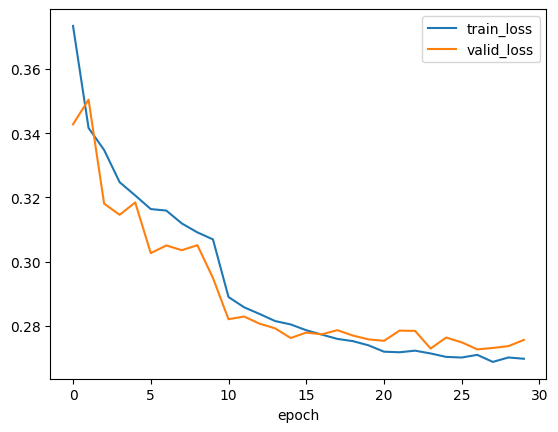

In [18]:
plt.xlabel("epoch")
plt.plot(proc_dict["train_loss"], label="train_loss")
plt.plot(proc_dict["val_loss"], label="valid_loss")
plt.legend()

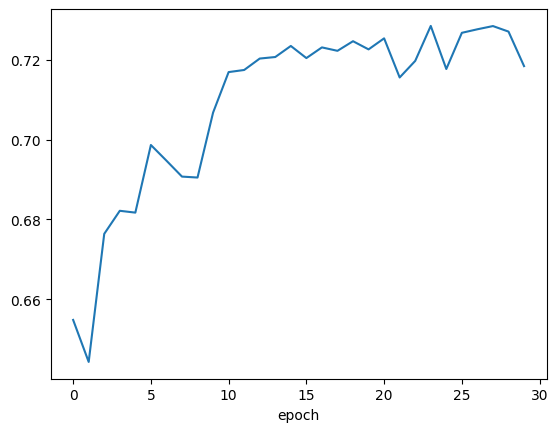

In [19]:
plt.xlabel("epoch")
plt.plot(proc_dict["metric_f1"], label="valid f1")